In [1]:
import sys,os,datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import fbeta_score
from __future__ import print_function

In [2]:
print(np.__version__);
print(pd.__version__);

1.12.1
0.19.2


In [3]:
import  cv2 as cv
cv.__version__

'3.2.0'

In [4]:
sys.path.append('..')
from helper import formFH, paths_input

In [5]:
#from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential,save_model,load_model
from keras.layers import Convolution2D, MaxPooling2D, Convolution1D, MaxPooling1D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers.normalization import BatchNormalization
import keras.optimizers

Using TensorFlow backend.


In [6]:
trLabels,trDirTIF,trDirJPG,_,_ = paths_input()
trDir = trDirTIF
trDir

'../Data/train-tif-v2'

In [7]:
labels_df = pd.read_csv(trLabels)
labels_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [9]:
# Build list with unique labels
label_list = []
for tag_str in labels_df.tags.values:
    labels = tag_str.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)

In [10]:
# Add onehot features for every label
for label in label_list:
    labels_df[label] = labels_df['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)
    #labels_df[label].astype(np.int8)
# Display head
#labels_df.head()


In [11]:
weather_labels = ['clear', 'partly_cloudy', 'haze', 'cloudy']
land_labels = ['primary', 'agriculture', 'water', 'cultivation', 'habitation' ]
rare_labels = [l for l in label_list if labels_df[label_list].sum()[l] < 2000]
#rare_labels              

In [12]:
labels = label_list; #weather_labels;
nameList =labels_df[labels_df[labels].sum(axis=1)>0].image_name.tolist(); len(nameList)
labelList=labels_df[labels_df[labels].sum(axis=1)>0][labels].as_matrix();
labelList[:6,:]
#labels_df.head()

array([[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [12]:
def formMM (nf, printOK=False) :
    nx = None
    try : 
        ni = cv.imread(nf,-1); 
        if (ni is not None) :
            if not ((ni.shape[2]==3) or (ni.shape[2]==4)) and printOK : print('----- error ---- shape:',ni.shape,nf)
            if (ni.shape[2]==3) :
                rmin,gmin,bmin = ni[:,:,0].min(),ni[:,:,1].min(),ni[:,:,2].min()
                rmax,gmax,bmax = ni[:,:,0].max(),ni[:,:,1].max(),ni[:,:,2].max()
                nx = np.array([[rmin,rmax],[gmin,gmax],[bmin,bmax]]); 
                
            if (ni.shape[2]==4) :
                r,g,b,n = ni[:,:,2],ni[:,:,1],ni[:,:,1],ni[:,:,3]
                dv = np.divide((r-n),(r+n+0.01))
                dw = np.divide((g-n),(g+n+0.01))
                rmin,gmin,bmin,nmin = ni[:,:,2].min(),ni[:,:,1].min(),ni[:,:,0].min(),n.min()
                rmax,gmax,bmax,nmax = ni[:,:,2].max(),ni[:,:,1].max(),ni[:,:,0].max(),n.max()
                
                vmin,wmin      = dv[:].min(),dw[:].min()
                vmax,wmax      = dv[:].max(),dw[:].max()
                nx = np.array([[rmin,rmax],[gmin,gmax],[bmin,bmax],[nmin,nmax],[vmin,vmax],[wmin,wmax]]); 
                
    except BaseException as e :
        print(nf,e); nx = None;
    
    if (nx is None) and printOK : print('------ None:',nf)
        
    return(nx)


In [55]:
# Estimate colors ranges

In [58]:
i, size = 0, len(nameList)
trMM = []
print(datetime.datetime.now(),len(nameList),size)
for nn in nameList[0:size] :
    #nf = os.path.join(trDirJPG,nn+".jpg");
    nf = os.path.join(trDirTIF,nn+".tif");
    nx = formMM(nf)
    if (nx is not None) :
        #print(nx.flatten())
        trMM.append(nx.flatten())
    i += 1
    if (i%5000==0) : print(datetime.datetime.now(),"\t",i,"\t",nn)
    #print(nn.shape)
    
print(datetime.datetime.now())
trMM = np.array(trMM); 
trMin = trMM.min(axis=0)
trMM[0:3]
trMin

2017-05-13 19:31:59.011137 40479 40479
2017-05-13 19:34:35.411171 	 5000 	 train_4999
2017-05-13 19:37:06.764807 	 10000 	 train_9999
2017-05-13 19:39:36.790461 	 15000 	 train_14999
2017-05-13 19:42:07.421276 	 20000 	 train_19999
2017-05-13 19:44:38.506238 	 25000 	 train_24999
2017-05-13 19:47:12.424019 	 30000 	 train_29999
2017-05-13 19:49:44.839824 	 35000 	 train_34999
2017-05-13 19:52:21.607393 	 40000 	 train_39999
2017-05-13 19:52:35.690417


array([  0.00000000e+00,   2.85100000e+03,   1.10100000e+03,
         2.10000000e+03,   0.00000000e+00,   1.40600000e+03,
         5.13000000e+02,   8.30000000e+02,   0.00000000e+00,
         8.92799286e-02,   0.00000000e+00,   9.76749175e-02])

In [92]:
trMin = trMM.min(axis=0)
trMax = trMM.max(axis=0)
trMMM = np.array([trMM.min(axis=0),trMM.max(axis=0)]); trMMM.shape
trMMM = np.array([[trMMM[0,i],trMMM[1,i+1]] for i in range(0,trMMM.shape[1],2)])
print(trMMM.shape,'\n',trMMM)

(6, 2) 
 [[  0.00000000e+00   3.41660000e+04]
 [  1.10100000e+03   2.46500000e+04]
 [  0.00000000e+00   2.94430000e+04]
 [  5.13000000e+02   3.97860000e+04]
 [  0.00000000e+00   1.85687711e+01]
 [  0.00000000e+00   1.94794186e+01]]


In [93]:
np.save('../Data-Keras/train-basin-020-1D-2-MM-tif-v2.npy',np.array(trMMM))

In [113]:
def formFHMMM (nf, bins, mmm, printOK=False) :
    nx = []
    try : 
        ni = cv.imread(nf,-1); 
        if (ni is not None) :
            if not ((ni.shape[2]==3) or (ni.shape[2]==4)) and printOK : print('----- error ---- shape:',ni.shape,nf)
            if (ni.shape[2]==3) :
                r,g,b = ni[:,:,0],ni[:,:,1],ni[:,:,2]
                for im,mm in zip([r,g,b],mmm.tolist()) :
                    im1 = np.clip(im.astype(np.float32),mm[0],mm[1])
                    im1 = (im1-mm[0])/(mm[1]-mm[0])*bins;
                    hh1 = np.divide(np.histogram(im1,bins=bins,density=False)[0],(0.0+im1.size))
                    nx.append(hh1)
                nx = np.array(nx).flatten(); 
            if (ni.shape[2]==4) :
                r,g,b,n = ni[:,:,2],ni[:,:,1],ni[:,:,1],ni[:,:,3]
                dv = np.divide((r-n),(r+n+0.01))
                dw = np.divide((g-n),(g+n+0.01))
                for im,mm in zip([r,g,b,n,dv,dw],mmm.tolist()) :
                    im1 = np.clip(im.astype(np.float32),mm[0],mm[1])
                    im1 = (im1-mm[0])/(mm[1]-mm[0])*bins;
                    hh1 = np.divide(np.histogram(im1,bins=bins,density=False)[0],(0.0+im1.size))
                    nx.append(hh1)
                nx = np.array(nx).flatten(); 
    except BaseException as e :
        print(nf,e); nx = None;
    
    if len(nx)==0 and printOK : 
        print('------ None:',nf); nx = None
        
    return(nx)

In [118]:
trX, trY, i, size = [],[], 0, len(nameList)
step=10; bins=[x for x in range(0,255+step,step)] # RGB -> 0..255
step=300; bins=[x for x in range(0,65535+step+1,step)] # BGRN -> 0..65535
bins=200
print(datetime.datetime.now(),len(nameList),size)
for nn in nameList[0:size] :
    #nf = os.path.join(trDirJPG,nn+".jpg");
    nf = os.path.join(trDirTIF,nn+".tif");
    nx = formFHMMM(nf,bins,trMMM)
    if (nx is not None) :
        nx=nx.reshape(nx.shape+(1,))
        trX.append(nx)
        trY.append(True)
    else : 
        trY.append(False)
    i += 1
    if (i%5000==0) : print(datetime.datetime.now(),"\t",i,"\t",nn)
    #print(nn.shape)

print(datetime.datetime.now())
len(trX)
trX = np.array(trX);
trY = labelList[trY];
print(len(nameList),trX.shape,trY.shape)

2017-05-14 00:06:17.623250 40479 40479
2017-05-14 00:09:45.009842 	 5000 	 train_4999
2017-05-14 00:13:43.232455 	 10000 	 train_9999
2017-05-14 00:18:33.484044 	 15000 	 train_14999
2017-05-14 00:24:51.345644 	 20000 	 train_19999
2017-05-14 00:30:58.181382 	 25000 	 train_24999
2017-05-14 00:37:15.448110 	 30000 	 train_29999
2017-05-14 00:43:31.686135 	 35000 	 train_34999
2017-05-14 00:49:53.451916 	 40000 	 train_39999
2017-05-14 00:50:28.044197
40479 (40479, 1200, 1) (40479, 17)


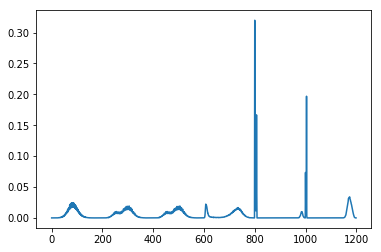

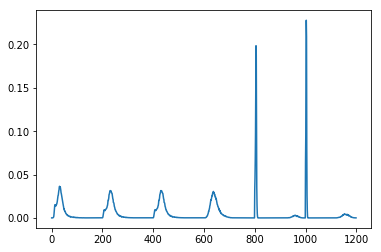

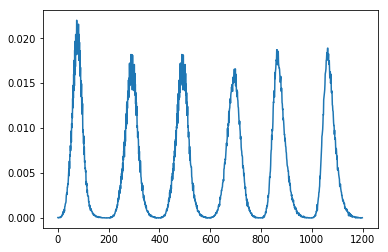

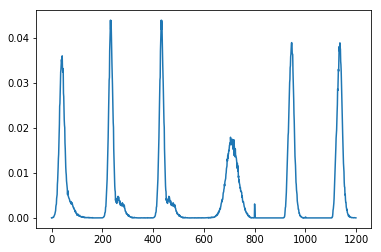

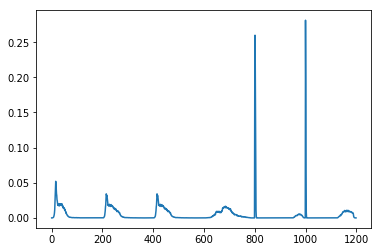

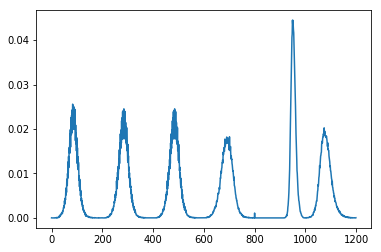

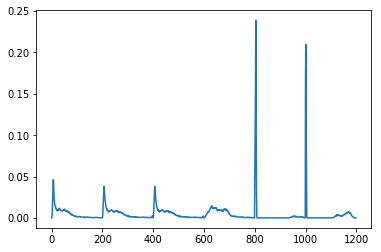

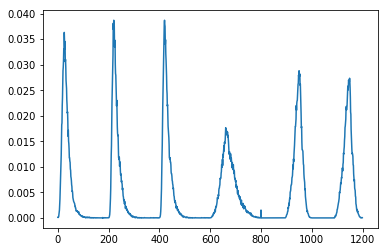

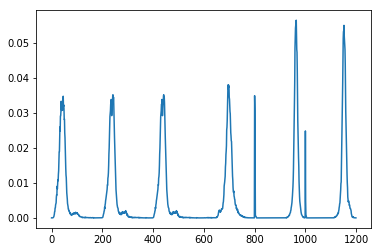

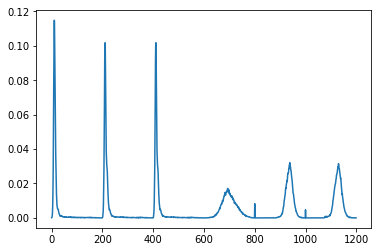

In [119]:
for i in range(trX.shape[0]-10,trX.shape[0]) :
    plt.plot(trX[i]); plt.show()

In [120]:
np.save('../Data-Keras/train-basin-020-1D-2-X-tif-v2.npy',trX)
np.save('../Data-Keras/train-basin-020-1D-2-Y-tif-v2.npy',trY)
np.save('../Data-Keras/train-basin-020-1D-2-L-tif-v2.npy',np.array(labels))
np.save('../Data-Keras/train-basin-020-1D-2-MM-tif-v2.npy',trMMM)

In [13]:
trX = np.load('../Data-Keras/train-basin-020-1D-2-X-tif-v2.npy')
trY = np.load('../Data-Keras/train-basin-020-1D-2-Y-tif-v2.npy')
print(trX.shape,trY.shape)

(40479, 1200, 1) (40479, 17)


In [17]:
import keras.backend as K
def fbeta_pred(y_true, y_pred, beta=2.0, OK1=0.2, eps=0.000001, printOK=False):
    beta2 = beta*beta
    yy_true = K.round(y_true)
    #yy_pred = K.round(y_pred+(0.5-OK1))
    yy_pred = K.round(y_pred)
    tp, tp_fp, fn = K.sum((yy_pred*yy_true)), K.sum(yy_true), K.sum((K.abs(yy_pred*(yy_true-1.0))))
    precision, recall = tp/(tp_fp+eps), tp/(tp+fn+eps) 
    fbeta = (1+beta2)*(precision*recall)/(beta2*precision+recall+eps)
    ##if fbeta>1.0 : fbeta = 1.0;
    if printOK :
        print('ten true ',K.get_value(yy_true))
        #print('ten pred ',y_pred)
        print('ten roun ',K.get_value(yy_pred))
        print(' pre=',K.get_value(precision),' recall=',K.get_value(recall),' tp=',
              K.get_value(tp),' fn=',K.get_value(fn),' tp+fp=',K.get_value(tp_fp))
    return(fbeta)

In [16]:
4096+4096+4096+4096+16384

32768

In [19]:
#
#
#

ss = trX.shape[1]
rr = trY.shape[1]

model = Sequential()
model.add(BatchNormalization(input_shape=(ss,1)))
#model.add(Dense(ss*10, input_shape=(ss,1))) # ?????
model.add(Dense(64)) # ?????
model.add(Activation('relu'))
model.add(Dropout(0.50))

model.add(Flatten())

model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(32768))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(rr,activation='sigmoid'))

sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd, #"adam", #'rmsprop',
              metrics=[fbeta_pred]) #['accuracy',fbeta_pred]) #['accuracy'])

In [32]:
# badly don't work: fail customs metric # model=load_model('../Data-Keras/basin02-loop-all.h5') ## verify load from v1 version
model.load_weights('../Data-Keras/train-model-020-1D-2-v2-loop-weights.h5') ## verify load weights from v1 version

In [20]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
batchnormalization_4 (BatchNorma (None, 1200, 1)       4           batchnormalization_input_4[0][0] 
____________________________________________________________________________________________________
dense_13 (Dense)                 (None, 1200, 64)      128         batchnormalization_4[0][0]       
____________________________________________________________________________________________________
activation_10 (Activation)       (None, 1200, 64)      0           dense_13[0][0]                   
____________________________________________________________________________________________________
dropout_10 (Dropout)             (None, 1200, 64)      0           activation_10[0][0]              
___________________________________________________________________________________________

In [22]:
print('time.begin :',datetime.datetime.now())
start = 0+808
steps = 64
model.fit(trX,trY,
         nb_epoch=5, #10,
         batch_size=128,
         validation_split=0.20,
         verbose=2
         )
        #samples_per_epoch=200)
        #validation_data=validation_generator,
        #initial_epoch=start,
        #nb_val_samples=2048
         #)
print('time.end   :',datetime.datetime.now())

time.begin : 2017-05-14 06:20:17.603758
Train on 32383 samples, validate on 8096 samples
Epoch 1/5
13s - loss: 4.8204 - fbeta_pred: 0.8073 - val_loss: 4.7980 - val_fbeta_pred: 0.8054
Epoch 2/5
13s - loss: 4.7904 - fbeta_pred: 0.8120 - val_loss: 4.7541 - val_fbeta_pred: 0.8160
Epoch 3/5
12s - loss: 4.7731 - fbeta_pred: 0.8142 - val_loss: 4.7488 - val_fbeta_pred: 0.8181
Epoch 4/5
13s - loss: 4.7485 - fbeta_pred: 0.8210 - val_loss: 4.7198 - val_fbeta_pred: 0.8224
Epoch 5/5
13s - loss: 4.7300 - fbeta_pred: 0.8229 - val_loss: 4.7085 - val_fbeta_pred: 0.8306
time.end   : 2017-05-14 06:21:23.136770


In [31]:
save_model(model,'../Data-Keras/train-model-020-1D-2-v2-all.h5')
model.save_weights('../Data-Keras/train-model-020-1D-2-v2-weights.h5')  # save weights after training

In [30]:
print(model.evaluate(trX,trY,verbose=2))
trP = model.predict(trX, batch_size=128)
print(trY.shape)
print(trP.shape)
print(fbeta_score(trY, np.array(trP) > 0.2, beta=2, average='samples'))
####print(fbeta_score(trY, np.array(trP) > 0.15, beta=2, average='samples'))

[3.7896822094401927, 0.96416370018147157]
(40479, 17)
(40479, 17)
0.964569202368


In [24]:
print(K.get_value(fbeta_pred(trY.astype(np.float64),trP.astype(np.float64))))
trP[-1]

0.8329069329


array([  5.62055642e-03,   9.72620070e-01,   5.33147931e-01,
         2.57149637e-01,   1.03963576e-01,   2.75583804e-01,
         3.43835711e-01,   2.76672155e-01,   1.96136273e-02,
         4.07406682e-04,   6.18941545e-01,   2.80000037e-03,
         2.43441481e-02,   3.92373512e-03,   6.25908282e-03,
         7.82593526e-03,   7.71450670e-03], dtype=float32)

In [32]:
print('time.begin :',datetime.datetime.now())
beta_old = 0.0
trP = model.predict(trX, batch_size=512)
beta_old = fbeta_score(trY, np.array(trP) > 0.2, beta=2, average='samples')
print(datetime.datetime.now(),0,beta_old,model.evaluate(trX,trY,verbose=2))
for i in range(30) :
    model.fit(trX,trY,
             nb_epoch=10,
             batch_size=128,
             validation_split=0.20,
             verbose=0
             )
    trP = model.predict(trX, batch_size=512)
    beta_new = fbeta_score(trY, np.array(trP) > 0.2, beta=2, average='samples')
    print(datetime.datetime.now(),i,beta_new,"(",beta_old,")",model.evaluate(trX,trY,verbose=2))
    if ((beta_old+0.003)<beta_new) :
        save_model(model,  '../Data-Keras/train-model-020-1D-2-v2-loop-all.h5')
        model.save_weights('../Data-Keras/train-model-020-1D-2-v2-loop-weights.h5')  # save weights after training
        beta_old = beta_new
print('time.end   :',datetime.datetime.now())

time.begin : 2017-05-14 17:29:20.187388
2017-05-14 17:29:22.471890 0 0.964569202368 [3.7896822094401927, 0.96416370018147157]
2017-05-14 17:31:57.933861 0 0.964817858183 ( 0.964569202368 ) [3.7779964885797899, 0.96420315743293705]
2017-05-14 17:34:33.564698 1 0.96507281484 ( 0.964569202368 ) [3.7826745440070022, 0.96479257507084382]
2017-05-14 17:37:09.381605 2 0.965343393665 ( 0.964569202368 ) [3.7776715995006205, 0.96439496263831836]
2017-05-14 17:39:45.363962 3 0.965227346085 ( 0.964569202368 ) [3.7720837219892487, 0.9656257821671379]
2017-05-14 17:42:21.233462 4 0.964833398252 ( 0.964569202368 ) [3.7767203195360284, 0.96437850035492345]
2017-05-14 17:44:57.115660 5 0.965361449266 ( 0.964569202368 ) [3.7812219725675522, 0.96480570235811103]
2017-05-14 17:47:32.641218 6 0.964792800059 ( 0.964569202368 ) [3.7775752554003668, 0.96452107929324071]
2017-05-14 17:50:08.561151 7 0.965298447685 ( 0.964569202368 ) [3.778632100602231, 0.96554574994643438]
2017-05-14 17:52:44.588135 8 0.965593

In [33]:
rr, rrx = [], []; trP = model.predict(trX, batch_size=512)
for i in range(trP.shape[1]) :
    xx = [];
    trYY = trY[:,i].astype(np.float64)
    trPY = trP[:,i]
    for ii in range(100) :
        trPP = (trPY>0.01*ii).astype(np.float64)
        #x = fbeta_score(trY[:,0], np.array(trP[:,0] > 0.1*ii), beta=2, average='samples')
        x = K.get_value(fbeta_pred(trYY,trPP))
        xx.append(x)
    rrr = np.array(xx).argmax();
    rr.append(rrr)
    rrx.append(xx[rrr])
    print(datetime.datetime.now(),i,'-->',rrr,xx[rrr],xx[(rrr-1):(rrr+2)])
    #print(xx);
    #plt.plot(np.array(xx)); plt.show()
trM = np.array(rr)/100.0;

2017-05-14 18:49:21.181592 0 --> 69 0.933772406578 [0.93347171560885267, 0.93377240657814409, 0.93291997198879117]
2017-05-14 18:51:05.893646 1 --> 68 0.992795381119 [0.99277650181034449, 0.99279538111936494, 0.99278835115248132]
2017-05-14 18:52:56.577043 2 --> 67 0.954488431201 [0.95430063791108266, 0.95448843120120763, 0.95411249426982814]
2017-05-14 18:54:53.552400 3 --> 57 0.982924817763 [0.98277291744686757, 0.9829248177627492, 0.98283685014269617]
2017-05-14 18:56:56.508332 4 --> 66 0.953200559565 [0.95306259336089982, 0.95320055956514071, 0.95299602902240343]
2017-05-14 18:59:05.349657 5 --> 59 0.94823480289 [0.94784746986502788, 0.94823480289015438, 0.94774325502322254]
2017-05-14 19:01:19.972458 6 --> 75 0.9423564986 [0.94234163496669987, 0.94235649860036452, 0.94216832604586764]
2017-05-14 19:03:40.273623 7 --> 74 0.933677686978 [0.93324124319031265, 0.93367768697755682, 0.9334767238099676]
2017-05-14 19:06:05.815567 8 --> 85 0.945157290241 [0.94076631528722621, 0.9451572902

In [34]:
print(trM,'\n',np.array(labels),'\n',rrx,'\n',(np.array(rrx)).mean())

[ 0.69  0.68  0.67  0.57  0.66  0.59  0.75  0.74  0.85  0.62  0.83  0.63
  0.85  0.83  0.67  0.82  0.74] 
 ['haze' 'primary' 'agriculture' 'clear' 'water' 'habitation' 'road'
 'cultivation' 'slash_burn' 'cloudy' 'partly_cloudy' 'conventional_mine'
 'bare_ground' 'artisinal_mine' 'blooming' 'selective_logging' 'blow_down'] 
 [0.93377240657814409, 0.99279538111936494, 0.95448843120120763, 0.9829248177627492, 0.95320055956514071, 0.94823480289015438, 0.94235649860036452, 0.93367768697755682, 0.94515729024076733, 0.95240455248715195, 0.96759549750785712, 0.96064791465733068, 0.93907893839376577, 0.95574064375533718, 0.9357140562398506, 0.93481351993985629, 0.951219273230275] 
 0.951989545362


In [28]:
print(trM,'\n',np.array(labels),'\n',rrx,'\n',(np.array(rrx)).mean())

[ 0.66  0.66  0.69  0.73  0.61  0.7   0.67  0.76  0.85  0.77  0.78  0.48
  0.84  0.67  0.53  0.76  0.7 ] 
 ['haze' 'primary' 'agriculture' 'clear' 'water' 'habitation' 'road'
 'cultivation' 'slash_burn' 'cloudy' 'partly_cloudy' 'conventional_mine'
 'bare_ground' 'artisinal_mine' 'blooming' 'selective_logging' 'blow_down'] 
 [0.92224065777708086, 0.99159348220094068, 0.94863901562529329, 0.9818389816594616, 0.94725335810698508, 0.94252921125648881, 0.93341046605927203, 0.92639769583039766, 0.94076631528722621, 0.94996426851000626, 0.96564389293424469, 0.96064791465733068, 0.93522130630549472, 0.95592778438201542, 0.90339209593715952, 0.9330482003241205, 0.94827562149657341] 
 0.946281780491


In [35]:
np.save('../Data-Keras/train-basin-020-1D-2-M-tif-V2.npy',trM)
np.save('../Data-Keras/train-basin-020-1D-2-L-tif-V2.npy',np.array(labels))
save_model(model,  '../Data-Keras/train-model-020-1D-2-v2-loop-all.h5')
model.save_weights('../Data-Keras/train-model-020-1D-2-v2-loop-weights.h5')  # save weights after training

In [93]:
imgTIF = os.path.join(trDir,trfiles[1])
imgJPG = os.path.join(trDirJPG,os.path.splitext(trfiles[1])[0]+".jpg")
img  = cv.imread(imgTIF,-1); img.shape
jpg  = cv.imread(imgJPG,-1); jpg.shape

(256, 256, 3)

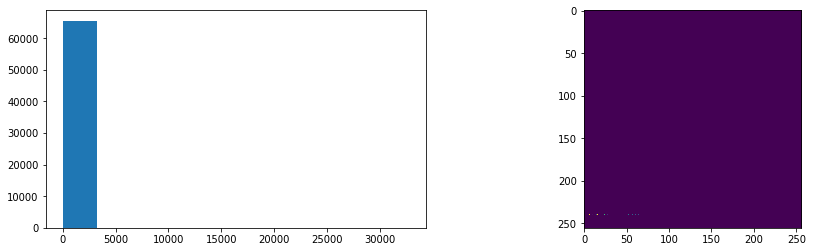

In [95]:
fig = plt.figure()
fig.set_size_inches(15, 4)
ndvi = np.divide((img[:,:,2]-img[:,:,3]),(img[:,:,2]+img[:,:,3]+1))
fig.add_subplot(121); plt.hist(ndvi.ravel());
fig.add_subplot(122); plt.imshow(ndvi); 
plt.show(); 

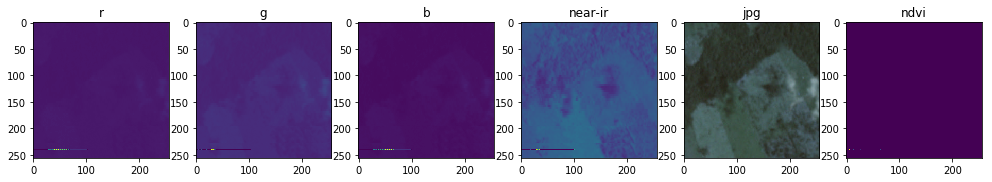

In [96]:
b,g,r,n = img[:,:,0], img[:,:,1], img[:,:,2], img[:,:,3];

fig = plt.figure();
fig.set_size_inches(17, 8);
for i, (x, c) in enumerate(((r, 'r'), (g, 'g'), (b, 'b'), (n, 'near-ir'))):
    x  = x.copy().astype("float32"); x -= x.mean(); x /= x.std();
    a = fig.add_subplot(1, 6, i+1); a.set_title(c); plt.imshow(x)
a = fig.add_subplot(1, 6, 5); a.set_title("jpg"); plt.imshow(jpg); 
a = fig.add_subplot(1, 6, 6); a.set_title("ndvi"); plt.imshow(ndvi);
plt.show()


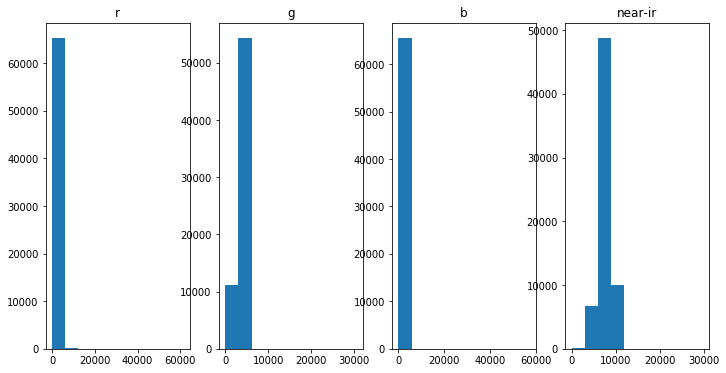

0 0 0 0
61440 57344 30575 29742
4032.98484802 2445.16603088 3586.4861145 7574.25961304
844.909376225 925.720809756 564.643057569 1385.98644852


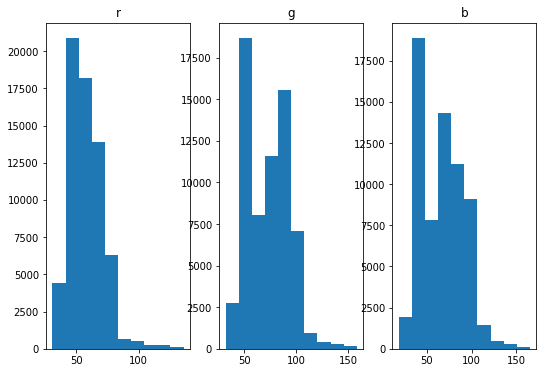

In [98]:
fig = plt.figure()
fig.set_size_inches(15, 6)
for i, (x, c) in enumerate(((r, 'r'), (g, 'g'), (b, 'b'), (n, 'near-ir'))):
    #x  = x.copy().astype("float32"); x -= x.mean(); x /= x.std();
    a = fig.add_subplot(1, 5, i+1); a.set_title(c); plt.hist(x.ravel())
##fig.add_subplot(1, 5, 5); plt.imshow(jpg); plt.show(); 
plt.show()
print(r.min(),b.min(),g.min(),n.min())
print(r.max(),b.max(),g.max(),n.max())
print(r.mean(),b.mean(),g.mean(),n.mean())
print(r.std(),b.std(),g.std(),n.std())

fig = plt.figure()
fig.set_size_inches(15, 6)
for i, (x, c) in enumerate(((jpg[:,:,0], 'r'), (jpg[:,:,1], 'g'), (jpg[:,:,2], 'b'))) :
    #x  = x.copy().astype("float32"); x -= x.mean(); x /= x.std();
    a = fig.add_subplot(1, 5, i+1); a.set_title(c); plt.hist(x.ravel())
##fig.add_subplot(1, 5, 5); plt.imshow(jpg); plt.show(); 
plt.show()

